In [1]:
import os
import sys
from typing import Optional
from pydantic import BaseModel
import numpy as np
import pandas as pd
from sklearn import linear_model



def exponential_weight(
    length: int = 100,
    alpha: float = None,
    com: float = None,
    span: float = None,
    halflife: int = None,
    adjust: bool = False,
) -> pd.Series:
    """
    Calculate exponential weight.

    Args:
        length (int, optional): length of weights. Defaults to 100.
        alpha (float, optional): exponential alpha. Defaults to None.
        com (float, optional): center of mass. Defaults to None.
        span (float, optional): exponential span. Defaults to None.
        halflife (int, optional): exponential halflife decay. Defaults to None.
        adjust (bool, optional): if sum to one. Defaults to False.

    Returns:
        pd.Series: exponential weight.
    """
    if com is not None:
        alpha = 1 / (1 + com)
    elif halflife is not None:
        alpha = 1 - np.exp(-np.log(2) / halflife)
    elif span is not None:
        alpha = 2 / (span + 1)
    elif alpha is None:
        return None
    out = (
        pd.Series(data=list((1 - alpha) ** i for i in range(length)), name="weight")
        .iloc[::-1]
        .reset_index(drop=True)
    )
    if adjust:
        out /= out.sum()
    return out


def exposure(
    dependents: pd.DataFrame,
    independents: pd.DataFrame,
    model: str = "linear",
    window: int = None,
    positive: bool = False,
    fit_intercept: bool = False,
    max_loss: float = 0.2,
    alpha: float = None,
    com: float = None,
    span: float = None,
    halflife: float = None,
) -> pd.DataFrame:
    """
    Calculate asset exposure to factors

    Args:
        dependents (pd.Series): price of asset.
        independents (pd.DataFrame): price of factor
        model (str, optional): regression model. Defaults to 'linear'.
        window (int, optional): rolling window. Defaults to None.
        positive (bool, optional): coefficient constraint. Defaults to False.
        fit_intercept (bool, optional): if fit intercept. Defaults to False.
        max_loss (float, optional): max loss percentage of data.
            Defaults to 0.80.
        alpha (float, optional): exponential alpha. Defaults to None.
        com (float, optional): center of mass. Defaults to None.
        span (float, optional): exponential span. Defaults to None.
        halflife (int, optional): exponential halflife decay. Defaults to None.
        adjust (bool, optional): if sum to one. Defaults to False.

    Returns:
        pd.DataFrame: exposure coefficient
    """

    if isinstance(dependents, pd.DataFrame):

        if window is None:

            return pd.concat(
                objs=list(
                    exposure(
                        dependents=dependents[x],
                        independents=independents,
                        model=model,
                        window=window,
                        max_loss=max_loss,
                        positive=positive,
                        fit_intercept=fit_intercept,
                        alpha=alpha,
                        com=com,
                        span=span,
                        halflife=halflife,
                    )
                    for x in dependents
                ),
                axis=1,
            ).T

        return pd.concat(
            objs=list(
                pd.concat(
                    objs=[
                        exposure(
                            dependents=dependents[x],
                            independents=independents,
                            model=model,
                            window=window,
                            max_loss=max_loss,
                            positive=positive,
                            fit_intercept=fit_intercept,
                            alpha=alpha,
                            com=com,
                            halflife=halflife,
                            span=span,
                        )
                    ],
                    keys=[x],
                    axis=1,
                )
                for x in dependents
            ),
            axis=1,
        )

    if window is not None:

        result = dict()

        for i in range(window, len(dependents) + 1):
            exposures = exposure(
                dependents=dependents.iloc[i - window : i],
                independents=independents,
                model=model,
                max_loss=max_loss,
                positive=positive,
                fit_intercept=fit_intercept,
                window=None,
                alpha=alpha,
                com=com,
                halflife=halflife,
                span=span,
            )
            if exposures is not None:
                result[dependents.index[i - 1]] = exposures

        return pd.DataFrame(result).T

    num = len(dependents)
    itx = dependents.index.intersection(independents.index)
    dependents = dependents.loc[itx]
    independents = independents.loc[itx]

    if len(dependents) / num < (1 - max_loss):
        print("max loss exceeded.")

    if model == "linear":

        regression_model = linear_model.LinearRegression(
            positive=positive, fit_intercept=fit_intercept
        )

    elif model == "lasso":

        regression_model = linear_model.LassoCV(
            positive=positive, fit_intercept=fit_intercept
        )

    elif model == "lasso+linear":

        expo = exposure(
            dependents=dependents,
            independents=independents,
            model="lasso",
            max_loss=max_loss,
            positive=positive,
            fit_intercept=fit_intercept,
            alpha=alpha,
            com=com,
            halflife=halflife,
            span=span,
        )

        expo = expo[expo != 0]

        return exposure(
            dependents=dependents,
            independents=independents.filter(items=expo.index),
            model="linear",
            max_loss=max_loss,
            positive=positive,
            fit_intercept=fit_intercept,
            alpha=alpha,
            com=com,
            halflife=halflife,
            span=span,
        )
    else:
        raise TypeError(f"model {model} not supported.")

    sample_weight = exponential_weight(
        length=len(dependents), alpha=alpha, com=com, halflife=halflife, span=span
    )

    regression_model.fit(
        X=independents,
        y=dependents,
        sample_weight=sample_weight,
    )

    betas = pd.Series(
        data=regression_model.coef_,
        index=independents.columns,
        name=dependents.name,
    )

    betas.loc["intercept"] = regression_model.intercept_

    betas.loc["score"] = regression_model.score(
        X=independents,
        y=dependents,
    )

    return betas


def get_pri_return(
    price: pd.DataFrame, periods: int = 1, forward: bool = False, **kwargs
) -> pd.DataFrame:
    """calculate price return"""
    freq = pd.DateOffset(**kwargs)
    if forward:
        freq = -freq
    _price = price.resample("D").last().ffill()
    out = _price.pct_change(periods=periods, freq=freq).loc[price.index]
    return out


def excess_performance(
    price_1: pd.DataFrame,
    price_2: pd.Series,
) -> pd.DataFrame:
    """calculate excess performance"""
    if not isinstance(price_1, pd.DataFrame):
        price_1 = pd.DataFrame(price_1)
    itx = price_1.index.intersection(price_2.index)
    price_1, price_2 = price_1.loc[itx], price_2.loc[itx]
    pri_return_1 = get_pri_return(price_1).fillna(0)
    pri_return_2 = get_pri_return(price_2).fillna(0)
    er = pri_return_1.subtract(pri_return_2, axis=0)
    return er.add(1).cumprod()


def risk_weighted_performance(price: pd.DataFrame, window: int = 252) -> pd.Series:
    """calculate risk based performance"""
    risk = price.pct_change().rolling(window=window).std().dropna(thresh=2, axis=0)
    weight = risk.divide(risk.sum(axis=1), axis=0)
    return (
        get_pri_return(price.loc[weight.index[0] :])
        .multiply(weight)
        .sum(axis=1)
        .add(1)
        .cumprod()
    )


def expsoures_implied_performance(
    exposures: pd.DataFrame, price_factor: pd.DataFrame
) -> pd.Series:
    """calculate exposure implied performance"""
    idx_date = price_factor.index.intersection(exposures.index)
    idx_factor = price_factor.columns.intersection(exposures.columns)
    if len(idx_date) == 0 or len(idx_factor) == 0:
        return None
    exposures = exposures.loc[idx_date, idx_factor]
    price_factor = price_factor.loc[idx_date, idx_factor]
    pri_return_factor = get_pri_return(price_factor.dropna())
    return (
        pri_return_factor.multiply(exposures)
        .dropna(how="all")
        .sum(axis=1)
        .add(1)
        .cumprod()
    )


class FactorLensSettings(BaseModel):

    rate: str = "LGY7TRUH"
    equity: str = "MXCXDMHR"
    uscredit: str = "LUACTRUU"
    eucredit: str = "LP05TRUH"
    usjunk: str = "LF98TRUU"
    eujunk: str = "LP01TRUH"
    commodity: str = "BCOMTR"
    localequity: str = "SPXT"
    shortvol: str = "PUT"
    localinflation: str = "BCIT5T"
    currency: str = "DXY"
    emergingequity: str = "M1EF"
    emergingbond: str = "EMUSTRUU"
    developedequity: str = "M1WD"
    developedbond: str = "LEGATRUU"
    momentum: str = "M1WD000$"
    value: str = "M1WD000V"
    growth: str = "M1WD000G"
    lowvol: str = "M1WDMVOL"
    smallcap: str = "M1WDSC"
    quality: str = "M1WDQU"


class FactorLens:
    def __init__(self, data: pd.DataFrame) -> None:

        self.data = data
        self.rate: Optional[pd.Series(dtype=float)] = None
        self.equity: Optional[pd.Series(dtype=float)] = None
        self.credit: Optional[pd.Series(dtype=float)] = None
        self.commodity: Optional[pd.Series(dtype=float)] = None
        self.emerging: Optional[pd.Series(dtype=float)] = None
        self.currency: Optional[pd.Series(dtype=float)] = None
        self.localequity: Optional[pd.Series(dtype=float)] = None
        self.localinflation: Optional[pd.Series(dtype=float)] = None
        self.shortvol: Optional[pd.Series(dtype=float)] = None
        self.momentum: Optional[pd.Series(dtype=float)] = None
        self.value: Optional[pd.Series(dtype=float)] = None
        self.growth: Optional[pd.Series(dtype=float)] = None
        self.smallcap: Optional[pd.Series(dtype=float)] = None
        self.lowvol: Optional[pd.Series(dtype=float)] = None
        self.process()

    def process(self) -> None:

        self.rate = self.data.rate.dropna()
        self.equity = self.data.equity.dropna()
        credit_performance = risk_weighted_performance(
            self.data[["uscredit", "eucredit", "usjunk", "eujunk"]].dropna()
        )
        self.credit = self.residualization(
            price=credit_performance,
            price_factor=pd.concat([self.rate, self.equity], axis=1).dropna(),
        ).squeeze()
        self.credit.name = "credit"

        self.commodity = self.residualization(
            price=self.data.commodity,
            price_factor=pd.concat([self.rate, self.equity], axis=1).dropna(),
        )

        self.commodity.name = "commodity"

        core_macro = pd.concat(
            objs=[self.rate, self.equity, self.credit, self.commodity], axis=1
        ).dropna()

        em_equity = excess_performance(
            self.data.emergingequity.dropna(), self.data.developedequity.dropna()
        )

        em_bond = excess_performance(
            self.data.emergingbond.dropna(), self.data.developedbond.dropna()
        )

        emerging = (
            risk_weighted_performance(pd.concat([em_equity, em_bond], axis=1).dropna())
            .dropna()
            .loc[core_macro.index[0] :]
        )

        self.emerging = self.residualization(
            price=emerging, price_factor=core_macro
        ).squeeze()
        self.emerging.name = "emerging"

        self.localinflation = self.residualization(
            price=self.data.localinflation.dropna().loc[core_macro.index[0] :],
            price_factor=core_macro,
        )

        self.localinflation.name = "localinflation"

        self.localequity = self.residualization(
            price=self.data.localequity.dropna().loc[self.equity.dropna().index[0] :],
            price_factor=self.equity.to_frame(),
        )
        self.localequity.name = "localequity"

        self.shortvol = self.residualization(
            price=self.data.shortvol.dropna().loc[self.equity.index[0] :],
            price_factor=self.equity.to_frame(),
        )
        self.shortvol.name = "shortvol"

        ccy = self.data.currency.resample("D").last().loc[core_macro.index]

        self.currency = self.residualization(price=ccy, price_factor=core_macro)
        self.currency.name = "currency"

        self.momentum = excess_performance(
            self.data.momentum.dropna(), self.data.developedequity.dropna()
        )
        self.momentum.name = "momentum"

        self.value = excess_performance(
            self.data.value.dropna(), self.data.developedequity.dropna()
        )
        self.value.name = "value"

        self.growth = excess_performance(
            self.data.growth.dropna(), self.data.developedequity.dropna()
        )
        self.growth.name = "growth"

        self.smallcap = excess_performance(
            self.data.smallcap.dropna(), self.data.developedequity.dropna()
        )
        self.smallcap.name = "smallcap"

        self.lowvol = excess_performance(
            self.data.lowvol.dropna(), self.data.developedequity.dropna()
        )
        self.lowvol.name = "lowvol"

        return self

    @property
    def performance(self):
        return pd.concat(
            objs=[
                self.rate,
                self.equity,
                self.credit,
                self.commodity,
                self.localinflation,
                self.emerging,
                self.localequity,
                self.currency,
                self.shortvol,
                self.momentum,
                self.value,
                self.lowvol,
                self.smallcap,
                self.growth,
            ],
            axis=1,
        )

    @staticmethod
    def residualization(
        price: pd.Series,
        price_factor: pd.DataFrame,
        window: int = 252 * 3,
        smoothing_window: int = 5,
        **kwargs,
    ) -> pd.Series:

        itx = price.index.intersection(price_factor.index)

        price = price.loc[itx]
        price_factor = price_factor.loc[itx]

        pri_return_1 = price.pct_change().fillna(0)
        pri_return_2 = price_factor.pct_change().fillna(0)

        betas = exposure(
            dependents=pri_return_1, independents=pri_return_2, window=window, **kwargs
        )

        if smoothing_window is not None:
            betas = betas.rolling(window=smoothing_window, min_periods=0).mean()

        perf_exposure = expsoures_implied_performance(
            exposures=betas, price_factor=price_factor
        )

        return excess_performance(price, perf_exposure)

from hive2 import db



# # swap dict
# kwargs = {v: k for k, v in FactorLensSettings().dict().items()}
# data = db.get_price(",".join(list(kwargs.keys())))
# data = data.rename(columns=kwargs)


import pandas as pd


prices_idx = pd.read_csv("index_price.csv", index_col=["date"], parse_dates=["date"])

lens = FactorLens(data=prices_idx)

perf = lens.performance
perf.index.name = "date"
perf.to_csv("factor_price.csv")

# perf = perf.stack().reset_index()
# perf.columns = ["date", "factor", "value"]
# with db.session_local() as session:
#     session.query(db.TbFactorIndex).delete()
#     session.flush()
#     session.bulk_insert_mappings(db.TbFactorIndex, perf.to_dict("records"))
#     session.commit()


ModuleNotFoundError: No module named 'hive2'

In [ ]:
tickers = ["LGY7TRUH Index", "MXCXDMHR Index", "LUACTRUU Index", "LP05TRUH Index",
           "LF98TRUU Index", "LP01TRUH Index", "BCOMTR Index", "SPXT Index", "PUT Index",
           "BCIT5T Index", "DXY Curncy", "M1EF Index", "EMUSTRUU Index", "M1WD Index",
           "LEGATRUU Index", "M1WD000$ Index", "M1WD000V Index", "M1WD000G Index",
           "M1WDMVOL Index", "M1WDSC Index", "M1WDQU Index"]

from xbbg import blp

data = blp.bdh(tickers, "PX_LAST", "1997-1-1")

data




In [ ]:
name = {
    "LGY7TRUH Index": "rate",
    "MXCXDMHR Index": "equity",
    "LUACTRUU Index": "uscredit",
    "LP05TRUH Index": "eucredit",
    "LF98TRUU Index": "usjunk",
    "LP01TRUH Index": "eujunk",
    "BCOMTR Index": "commodity",
    "SPXT Index": "localequity",
    "PUT Index": "shortvol",
    "BCIT5T Index": "localinflation",
    "DXY Curncy": "currency",
    "M1EF Index": "emergingequity",
    "EMUSTRUU Index": "emergingbond",
    "M1WD Index": "developedequity",
    "LEGATRUU Index": "developedbond",
    "M1WD000$ Index": "momentum",
    "M1WD000V Index": "value",
    "M1WD000G Index": "growth",
    "M1WDMVOL Index": "lowvol",
    "M1WDSC Index": "smallcap",
    "M1WDQU Index": "quality",
}

data = data.rename(columns=name)

data.to_csv("index_price.csv")

[*********************100%***********************]  103 of 103 completed
{'XLK': 0.1362, 'QQQ': 0.1426, 'VUG': 0.1447, 'XLY': 0.1265, 'PGX': 0.1132, 'IGLB': 0.0868, 'AOM': 0.0409, 'RWR': 0.0091, 'SHV': 0.0853, 'BIL': 0.1147}
{'EWZ': 0.1369, 'XLY': 0.1618, 'QQQ': 0.1259, 'VUG': 0.1254, 'JNK': 0.0997, 'HYG': 0.1003, 'AOA': 0.0205, 'AOR': 0.0295, 'SHV': 0.0733, 'BIL': 0.1267}


<AxesSubplot:>

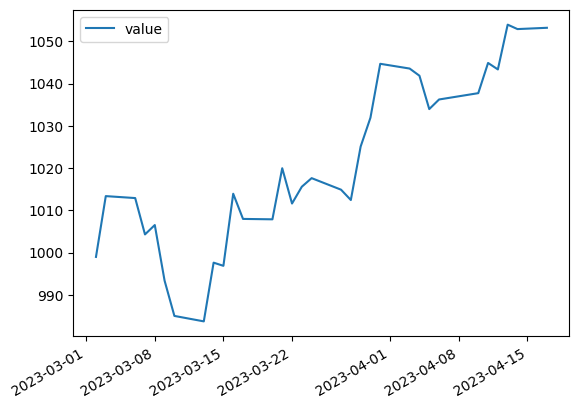

In [2]:
"""abl strategy"""
import yfinance as yf
from datetime import date, timedelta
from dateutil import parser
from pydantic import BaseModel
import pandas as pd
import riskfolio as rf
from core.analytics import metrics, USLEIHP
from core.strategy import BaseStrategy
from hive2 import db


class AlloSettings(BaseModel):
    """allocation settings"""

    model: str = "HRP"
    codependence: str = "pearson"
    covariance: str = "hist"
    rm: str = "MV"
    rf: float = 0.0
    linkage: str = "ward"
    max_k: int = 10
    leaf_order: bool = True


class RegrSettings(BaseModel):
    """regression settings"""

    method: str = "lasso"
    positive: bool = False
    fit_intercept: bool = False


class AssetClassNumAsset(BaseModel):
    """asset class num asset"""

    equity: int = 4
    fixedincome: int = 2
    alternative: int = 2
    liquidity: int = 2


class AssetClassSumWeight(BaseModel):
    """total of asset weight for each asset class"""

    equity: float
    fixedincome: float
    alternative: float
    liquidity: float

    @classmethod
    def from_level(cls, level: int = 5) -> "AssetClassSumWeight":
        """get asset class weight based on the risk level"""
        if level == 1:
            return cls(
                equity=0.05,
                fixedincome=0.10,
                alternative=0.05,
                liquidity=0.80,
            )
        if level == 2:
            return cls(
                equity=0.10,
                fixedincome=0.10,
                alternative=0.10,
                liquidity=0.70,
            )
        if level == 3:
            return cls(
                equity=0.30,
                fixedincome=0.15,
                alternative=0.05,
                liquidity=0.50,
            )
        if level == 4:
            return cls(
                equity=0.55,
                fixedincome=0.20,
                alternative=0.05,
                liquidity=0.20,
            )
        if level == 5:
            return cls(
                equity=0.80,
                fixedincome=0.10,
                alternative=0.05,
                liquidity=0.05,
            )
        raise NotImplementedError(
            "level only takes integers from 1 to 5. " + f"but {level} was given."
        )


class AblStrategy(BaseStrategy):
    frequency: str = "M"
    min_assets: int = 15
    min_periods: int = 252
    commission: int = 10

    @classmethod
    def load(
        cls,
        market: str = "us",
        level: int = 5,
        asofdate: str = date.today().strftime("%Y-%m-%d"),
        halflife: int = 21,
        regime_window: int = 252 * 5,
        regr_window: int = 21 * 3,
        positive: bool = True,
        clip: bool = True,
    ) -> "AblStrategy":
        """load predefined settings"""
        # strategy = f"abl_{market}"
        cls.asset_classes = ["equity", "fixedincome", "alternative", "liquidity"]
        cls.acna = AssetClassNumAsset().dict()
        cls.acsw = AssetClassSumWeight.from_level(level=level).dict()
        cls.price_factor = pd.read_csv(
            "factor_price.csv", index_col="date", parse_dates=True
        ).dropna()

        # cls.universe = db.load_universe("mlp_us")
        cls.universe = pd.read_csv("universe.csv", index_col="ticker")
        price_asset = yf.download(cls.universe.index.tolist())["Adj Close"]
        cls.regime = USLEIHP()
        cls.allo_settings = AlloSettings().dict()
        cls.regr_settings = RegrSettings(positive=positive).dict()
        cls.halflife = halflife
        cls.regime_window = regime_window
        cls.regr_window = regr_window
        cls.clip = clip
        return cls(
            price_asset=price_asset,
            frequency=cls.frequency,
            min_assets=cls.min_assets,
            min_periods=cls.min_periods,
            commission=cls.commission,
            name=f"abl_{market}_{level}",
        )

    @staticmethod
    def allocate_weights(pri_returns: pd.DataFrame, **kwargs) -> pd.Series:
        """calculate weights"""
        port = rf.HCPortfolio(returns=pri_returns)
        return port.optimization(**kwargs)["weights"]

    @staticmethod
    def make_views(views: pd.Series) -> list:
        """make list of views on expected returns"""
        return [
            {"assets": factor, "sign": ">", "value": expected_return}
            for factor, expected_return in views.items()
        ]

    def rebalance(self, price_asset: pd.DataFrame) -> pd.Series:
        """rebalance function"""
        state = self.regime.get_state(self.date.strftime("%Y-%m-%d"))
        exp_ret_states = self.regime.expected_returns_by_states(
            price_df=self.price_factor.loc[: self.date].iloc[-self.regime_window :]
        )
        views = self.make_views(exp_ret_states.loc[state])
        prior_mu = metrics.expected_returns(
            self.price_factor.loc[: self.date], method="empirical"
        )
        prior_cov = metrics.covariance_matrix(
            self.price_factor.loc[: self.date],
            method="exponential",
            halflife=self.halflife,
        )
        post_mu, _ = metrics.blacklitterman(prior_mu, prior_cov, views)

        betas = metrics.regression(
            dependent_y=price_asset.iloc[-self.regr_window :],
            independent_x=self.price_factor.loc[: self.date],
            **self.regr_settings,
        )
        betas.to_csv("betas.csv")
        if self.clip:
            betas = betas.clip(lower=-1, upper=1)
        betas = betas.drop("score", axis=1)
        expected_returns = post_mu @ betas.T
        expected_returns.to_csv("expected_returns.csv")
        final_weights = {}
        for ac in self.asset_classes:
            ac_tickers = self.universe[self.universe.strg_asset_class == ac].index
            ac_num_select = self.acna[ac]
            ac_weight = self.acsw[ac]
            if len(ac_tickers) == 1:
                final_weights.update(pd.Series(index=ac_tickers, data=ac_weight))
                continue
            ac_tickers_rank = expected_returns.filter(
                items=ac_tickers, axis=0
            ).sort_values(ascending=False)
            asset_selection = ac_tickers_rank.nlargest(ac_num_select).index

            weights = self.allocate_weights(
                price_asset[asset_selection].pct_change().iloc[-252:],
                **self.allo_settings,
            )
            weights = weights * ac_weight
            weights = self.clean_weights(weights=weights, decimals=4)
            final_weights.update(pd.Series(weights))

        print(final_weights)
        return pd.Series(final_weights).fillna(0)


strategy = AblStrategy.load(
    market="US",
    level=4,
    halflife=21,
    regime_window=5 * 252,
    regr_window=21 * 6,
    clip=True,
    positive=False,
)
strategy.simulate(start="2023-03-01")

strategy.value_df.plot()


,AAXJ,ACWV,ACWX,AGG,AOA,AOM,AOR,ASHR,BAB,BIL,...,XLB,XLE,XLF,XLG,XLI,XLK,XLP,XLU,XLV,XLY
Date,,,,,,,,,,,,,,,,,,,,,
2023-03-27,66.300003,95.110001,47.400002,98.829422,61.771587,38.991192,48.725918,29.180000,26.540001,91.428085,...,77.379997,79.550003,31.420000,301.149994,97.720001,144.830002,73.360001,65.769997,127.820000,141.869995
2023-03-28,67.169998,95.339996,47.619999,98.679794,61.721729,38.961338,48.725918,29.270000,26.490000,91.447998,...,77.750000,80.779999,31.410000,299.750000,98.220001,144.149994,73.489998,65.949997,127.050003,141.699997
2023-03-29,67.370003,95.779999,48.060001,98.799500,62.439655,39.269844,48.984890,29.219999,26.540001,91.447998,...,78.830002,81.900002,31.870001,303.869995,99.650002,147.169998,73.900002,66.910004,127.400002,144.389999
2023-03-30,67.989998,96.169998,48.610001,98.909218,62.768707,39.379314,49.273739,29.590000,26.709999,91.467918,...,79.370003,82.260002,31.799999,305.929993,99.860001,148.880005,74.110001,67.199997,128.089996,145.649994
2023-03-31,67.870003,96.750000,48.770000,99.388000,63.406864,39.667915,49.831516,29.480000,26.879999,91.447998,...,80.660004,82.830002,32.150002,310.519989,101.180000,151.009995,74.709999,67.690002,129.460007,149.539993
2023-04-03,68.099998,97.300003,49.119999,99.820000,63.705997,39.856998,49.961002,29.850000,27.010000,91.470001,...,81.169998,86.580002,32.209999,311.709991,101.360001,150.770004,75.099998,67.230003,130.910004,148.169998
2023-04-04,68.010002,97.410004,49.110001,100.190002,63.450001,39.779999,49.900002,30.010000,27.059999,91.480003,...,80.000000,85.010002,31.910000,311.059998,99.089996,149.940002,74.949997,67.570000,130.929993,147.929993
2023-04-05,67.489998,97.839996,48.770000,100.529999,63.230000,39.820000,49.830002,29.879999,27.230000,91.529999,...,79.820000,86.290001,31.870001,310.179993,97.800003,148.229996,75.300003,69.320000,133.190002,144.899994
2023-04-06,67.779999,98.139999,48.970001,100.440002,63.500000,39.880001,50.029999,29.950001,27.240000,91.540001,...,79.629997,84.980003,31.990000,312.250000,97.769997,149.070007,75.360001,69.809998,133.520004,144.929993


In [9]:
strategy.reb_weights_df.dropna(how="all").to_clipboard()

[*********************100%***********************]  2 of 2 completed


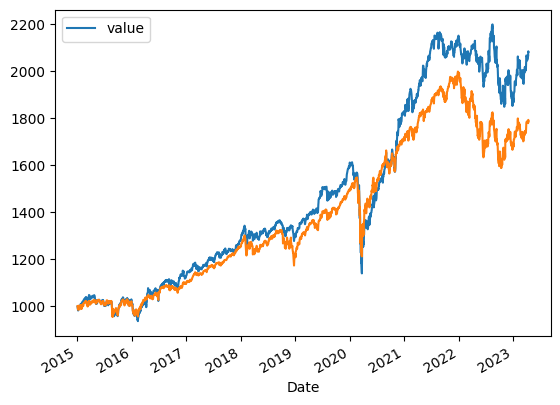

In [6]:
import yfinance as yf

w = dict(SPY=0.6, AGG=0.4)

p = yf.download(list(w.keys()))["Adj Close"].loc["2015-1-1":].pct_change().fillna(0)
r = p * w
bm = r.sum(axis=1).add(1).cumprod() * 1000
strategy.value_df.plot()
bm.plot();

In [ ]:
navs = pd.read_clipboard(index_col="date", parse_dates=True)
navs

In [4]:
navs = pd.concat([strategy.value_df, bm], axis=1)
navs.columns = ['value', 'benchmark']
navs.index.name = "date"
# navs.to_csv("navs.csv")

In [3]:
import empyrical as ep
import pandas as pd

navs = pd.read_clipboard(index_col="date", parse_dates=True)

ep.aggregate_returns(navs.pct_change().fillna(0), "monthly").to_clipboard()

In [28]:
from core.analytics.signal import USLEIHP
state = USLEIHP().states


In [20]:
state.to_frame().reset_index().groupby(by=0).count()

,date
0,
contraction,78
expansion,63
recovery,67
slowdown,71


{Timestamp('2015-01-02 00:00:00'): {'143850': 0.1926, '130730': 0.155, '152380': 0.1434, '133690': 0.1269, '139240': 0.1259, '117700': 0.1046, '148070': 0.0566, '153130': 0.045, '138230': 0.0253, '099140': 0.0247}, Timestamp('2015-02-02 00:00:00'): {'143850': 0.1673, '130730': 0.1523, '133690': 0.1491, '099140': 0.1344, '148070': 0.1235, '169950': 0.0992, '152380': 0.0765, '153130': 0.0477, '138230': 0.0253, '168580': 0.0247}, Timestamp('2015-03-02 00:00:00'): {'143850': 0.1646, '133690': 0.157, '130730': 0.1536, '099140': 0.1318, '148070': 0.1307, '169950': 0.0966, '152380': 0.0693, '153130': 0.0464, '138230': 0.0253, '168580': 0.0247}, Timestamp('2015-04-01 00:00:00'): {'130730': 0.1547, '133690': 0.152, '143850': 0.1481, '168580': 0.1388, '148070': 0.1346, '195930': 0.1111, '152380': 0.0654, '153130': 0.0453, '138230': 0.0253, '169950': 0.0247}, Timestamp('2015-05-01 00:00:00'): {'133690': 0.1857, '130730': 0.1577, '143850': 0.1487, '152380': 0.1351, '168580': 0.126, '195930': 0.089

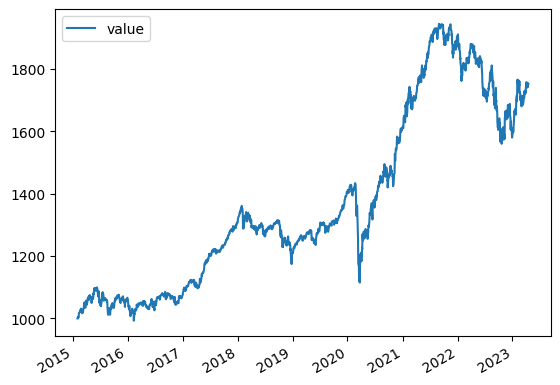

In [31]:
import pandas as pd
from core.analytics.metrics import backtest
from core.strategy import BaseStrategy
import pandas as pd
from sklearn.metrics.pairwise import euclidean_distances

level = 5

universe = pd.read_excel("Result.xlsx", sheet_name="universe")
price = pd.read_excel("Result.xlsx", sheet_name="prices", index_col="date", parse_dates=True).ffill()
allo = pd.read_excel("Result.xlsx", sheet_name="allocations", index_col="date", parse_dates=True)

kr_universe = universe[universe.market == "KS"]
kr_tickers = kr_universe.ticker.tolist()
kr_weights = {}

maps = []
for date, weights in allo.iterrows():
    kr_weights[date] = {}

    weights = weights[weights != 0].dropna().sort_values(ascending=False)

    p = price.loc[:date].iloc[-252 * 3:].dropna(thresh=200, axis=1).dropna()
    mask = p.columns.isin(kr_tickers)
    filtered_df = p.loc[:, mask]
    for asset, weight in weights.items():
        ac = universe[universe.ticker == asset]
        ac = ac.asset_class.iloc[0]
        kractickers = kr_universe[kr_universe.asset_class == ac].ticker.tolist()
        mask = filtered_df.columns.isin(kractickers)
        final_filtered_df = filtered_df.loc[:, mask]
        us_norm = (p[asset] - p[asset].mean()) / p[asset].std()
        distances = {}
        for kr in final_filtered_df:
            kr_norm = (final_filtered_df[kr] - final_filtered_df[kr].mean()) / final_filtered_df[kr].std()
            distance = euclidean_distances(kr_norm.values.reshape(1, -1), us_norm.values.reshape(1, -1))
            distances[kr] = distance[0][0]

        distances = pd.Series(distances).sort_values()
        select = distances.index[0]
        
        maps.append(pd.Series({"date": date, "us":asset, "w":weight, "kr":select}))
        kr_weights[date].update({select: weight})
        filtered_df = filtered_df.drop(select, axis=1)

print(kr_weights)

def backtest(allocation_df: pd.DataFrame, price_df: pd.DataFrame) -> BaseStrategy:
    """provide a backtested strategy.

    Args:
        allocation_df (pd.DataFrame): allocation dataframe.
        price_df (pd.DataFrame): asset price dataframe.

    Returns:
        BaseStrategy: backtested strategy.
    """
    class Backtest(BaseStrategy):
        """backtest class"""

        def rebalance(self, price_asset: pd.DataFrame) -> pd.Series:
            if self.date in allocation_df.index:
                weights =  allocation_df.loc[self.date].dropna()
                print(weights)
                return weights[weights !=0].dropna()
            return pd.Series(dtype=float)

    strategy = Backtest(price_asset=price_df, frequency="D").simulate(
        start=allocation_df.index[0]
    )

    return strategy
# us = backtest(allocation_df=allo, price_df=price.ffill())
allocation_df = pd.DataFrame(kr_weights).T
price_df = price[allocation_df.columns.tolist()].ffill().loc["2015":]
ss = backtest(allocation_df=allocation_df, price_df=price_df)
ss.value_df.plot()

from core.analytics import metrics
print(metrics.ann_returns(ss.value_df))
print(metrics.ann_volatilities(ss.value_df))
print(metrics.sharpe_ratios(ss.value_df))
# pd.DataFrame(kr_weights).T.fillna(0).to_csv("KR_5_allocation.csv")

In [34]:
w = ss.reb_weights_df.dropna(how="all").iloc[-1]
w = w[w != 0]
w

152380    0.1003
148070    0.0997
153130    0.0733
157450    0.1267
269540    0.1254
280930    0.1369
304940    0.1618
314250    0.1259
319640    0.0205
329650    0.0295
Name: 2023-04-04 00:00:00, dtype: float64

In [35]:
w.to_clipboard()